In [1]:
import numpy as np
import pandas as pd

from random import randint
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

from skimage.transform import resize

from keras.preprocessing.image import load_img
from keras import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input,Dense, AveragePooling2D,Conv2D, Conv2DTranspose,Flatten, MaxPooling2D, concatenate, Dropout,BatchNormalization,LeakyReLU,Activation,Add
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tqdm import tqdm_notebook
from keras import backend as K
from keras import optimizers
import time

Using TensorFlow backend.


In [2]:
data_df = pd.read_csv('./Mixed_Df.csv',index_col=0)
data = data_df.sample(frac=1).reset_index(drop=True)

In [3]:
data.head()

,Img1,Valid_Img,Img2,Target
0,163_dt.jpg,163_d.jpg,089_dt.jpg,0
1,157_dt.jpg,157_.jpg,157_t.jpg,1
2,141_.jpg,141_dt.jpg,061_.jpg,0
3,188_dt.jpg,188_d.jpg,188_.jpg,1
4,153_d.jpg,153_.jpg,153_t.jpg,1


In [4]:
img_path = '../cropped_GT'
imgs = os.listdir(img_path)

In [5]:
img_dic = {}
for img in imgs:
    img_dic[img] = np.array(load_img(img_path+'/'+img))/255
    print(img)
print('Read_Done')

140_d.jpg
016_dt.jpg
102_dt.jpg
054_t.jpg
171_d.jpg
164_.jpg
091_.jpg
048_t.jpg
020_dt.jpg
180_dt.jpg
177_dt.jpg
187_t.jpg
001_.jpg
064_dt.jpg
190_dt.jpg
118_dt.jpg
186_dt.jpg
064_.jpg
188_t.jpg
090_t.jpg
098_.jpg
179_t.jpg
033_d.jpg
052_d.jpg
048_d.jpg
160_d.jpg
066_dt.jpg
096_d.jpg
088_.jpg
152_d.jpg
136_t.jpg
143_.jpg
119_d.jpg
013_.jpg
006_.jpg
192_d.jpg
062_t.jpg
179_dt.jpg
193_t.jpg
172_.jpg
095_dt.jpg
019_.jpg
003_d.jpg
020_t.jpg
012_d.jpg
186_d.jpg
175_dt.jpg
184_t.jpg
022_.jpg
147_t.jpg
140_dt.jpg
126_.jpg
027_d.jpg
029_d.jpg
075_d.jpg
022_dt.jpg
130_.jpg
162_d.jpg
010_d.jpg
104_d.jpg
144_d.jpg
001_dt.jpg
004_t.jpg
040_dt.jpg
114_.jpg
151_d.jpg
094_d.jpg
072_dt.jpg
165_d.jpg
117_t.jpg
097_dt.jpg
169_dt.jpg
173_t.jpg
086_t.jpg
173_.jpg
072_d.jpg
120_dt.jpg
181_dt.jpg
031_.jpg
153_dt.jpg
080_t.jpg
128_t.jpg
070_d.jpg
094_t.jpg
123_.jpg
195_.jpg
063_.jpg
074_t.jpg
163_.jpg
056_t.jpg
060_d.jpg
122_dt.jpg
080_dt.jpg
042_dt.jpg
094_.jpg
071_dt.jpg
014_.jpg
141_.jpg
115_.jpg
178_dt.j

In [6]:
def Resblock_discriminator(layer_input,channels):
    h1 = Conv2D(channels,3,strides=1,padding='same')(layer_input)
    h1 = Activation('relu')(h1)
    h1 = Conv2D(channels,3,strides=1,padding='same')(h1)
    h1 = AveragePooling2D(pool_size=(2, 2))(h1)

    h2 = Conv2D(channels,1,strides=1,padding="valid")(layer_input)
    h2 = Activation('relu')(h2)
    h2 = AveragePooling2D(pool_size=(2, 2))(h2)
    return Add()([h2,h1])

def Resblock_discriminator_NP(layer_input,channels):
    h1 = Conv2D(channels,3,strides=1,padding='same')(layer_input)
    h1 = Activation('relu')(h1)
    h1 = Conv2D(channels,3,strides=1,padding='same')(h1)
    #h1 = AveragePooling2D(pool_size=(2, 2))(h1)

    h2 = Conv2D(channels,1,strides=1,padding="valid")(layer_input)
    h2 = Activation('relu')(h2)
    #h2 = AveragePooling2D(pool_size=(2, 2))(h2)
    return Add()([h2,h1])

In [7]:
def base_model(in_l):
    x = Conv2D(64,7,strides=2,padding='same')(in_l)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(3, 3),strides = 2)(x)
    
    x1 = Conv2D(64,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(64,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x = Add()([x,x2])
    x = Conv2D(128,3,padding='same')(x)
    """   
    x1 = Conv2D(128,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(128,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x = Add()([x,x2])
    x = MaxPooling2D(pool_size=(3, 3),strides = 2)(x)
    x = Conv2D(256,3,padding='same')(x)
    x1 = Conv2D(256,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(256,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x = Add()([x,x2])
    """
    x1 = Conv2D(128,3,padding='same')(x)
    x1 = BatchNormalization()(x1)
    x1 = Activation('relu')(x1)
    x2 = Conv2D(128,3,padding='same')(x1)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    
    x = Add()([x,x2])
    #x = Conv2D(64,3,padding='same')(x)
    return x
input_tensor = Input(shape=(224, 224, 3))
out_tensor = base_model(input_tensor)

In [8]:
feature_map = Model(inputs = input_tensor,outputs = out_tensor)
feature_map.trainable = True

In [9]:
feature_map.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 112, 112, 64) 256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 112, 112, 64) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
max_poolin

In [10]:
def build_feature_map(input_layer1,input_layer2,input_layer3,model):
    x1 = model(input_layer1)
    x2 = model(input_layer2)
    x3 = model(input_layer3)
    x3 = concatenate([x1,x2,x3],axis = -1)
    return x3

input_layer1 = Input((224, 224, 3),name='input1' )
input_layer2 = Input((224, 224, 3),name='input2')
input_layer3 = Input((224, 224, 3),name='input3')

output_layer = build_feature_map(input_layer1,input_layer2,input_layer3,feature_map)

In [11]:

def triplet_loss(y_true, y_pred):
    """
    Triplet Loss
    """
    MARGIN = 1.0
    anc, pos, neg = y_pred[:,:,:, 0:128], y_pred[:,:,:, 128:256], y_pred[:,:,:, 256:]

    # Euclidean Distance
    pos_dist = K.sum(K.square(anc - pos), axis=-1, keepdims=True)
    neg_dist = K.sum(K.square(anc - neg), axis=-1, keepdims=True)
    basic_loss = pos_dist - neg_dist + MARGIN

    loss = K.maximum(basic_loss, 0.0)

    print("[INFO] model - triplet_loss shape: %s" % str(loss.shape))
    return loss

In [12]:
model = Model(inputs = [input_layer1,input_layer2,input_layer3], outputs = output_layer)
model.summary()
model.trainable = True

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 55, 55, 128)  454144      input1[0][0]                     
                                                                 input2[0][0]                     
          

In [13]:
model.compile(loss=triplet_loss, optimizer=Adam())

[INFO] model - triplet_loss shape: (?, 55, 55, 1)


In [14]:
data.shape

(3112, 4)

In [15]:
train_data = data.iloc[0:2000,:]

In [16]:
x_1 = np.array([img_dic[k] for k in train_data['Img1']])
x_2 = np.array([img_dic[k] for k in train_data['Valid_Img']])
x_3 = np.array([img_dic[k] for k in train_data['Img2']])
target = np.array(train_data['Target'])


In [17]:
y_true = np.array([2000 * np.zeros((55,55,256))])

In [ ]:
model_checkpoint = ModelCheckpoint("./saved_model/Tri_feature_55x55.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(patience=20, verbose=1)
model.fit(x=[x_1,x_2,x_3],
            y=target,validation_split = 0.2,
            batch_size=16, epochs=100,verbose=1,
            callbacks=[early_stopping, model_checkpoint,reduce_lr]
         )

Train on 1600 samples, validate on 400 samples
Epoch 1/100
1600/1600 [==============================] - 18s 11ms/step - loss: 2.6945 - val_loss: 1.5504

Epoch 00001: val_loss improved from inf to 1.55038, saving model to ./saved_model/Tri_feature_55x55.model
Epoch 2/100
1600/1600 [==============================] - 17s 10ms/step - loss: 1.0152 - val_loss: 1.1883

Epoch 00002: val_loss improved from 1.55038 to 1.18832, saving model to ./saved_model/Tri_feature_55x55.model
Epoch 3/100
1600/1600 [==============================] - 17s 10ms/step - loss: 0.9469 - val_loss: 1.0352

Epoch 00003: val_loss improved from 1.18832 to 1.03523, saving model to ./saved_model/Tri_feature_55x55.model
Epoch 4/100
1600/1600 [==============================] - 17s 10ms/step - loss: 0.9204 - val_loss: 1.0073

Epoch 00004: val_loss improved from 1.03523 to 1.00727, saving model to ./saved_model/Tri_feature_55x55.model
Epoch 5/100
1600/1600 [==============================] - 17s 10ms/step - loss: 0.9099 - val_l

In [49]:
K.clear_session()

In [50]:
import gc

In [ ]:
del y_true

In [53]:
gc.collect()

8

In [20]:
feature_map2 = load_model('/home/wenjie/Desktop/earImageDataset/keras-frcnn-master.2/saved_model/Tri_feature.model',custom_objects={'triplet_loss':triplet_loss})

[INFO] model - triplet_loss shape: (?, 27, 27, 1)


In [30]:
feature_map2.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input3 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_7 (Model)                 (None, 27, 27, 64)   527936      input1[0][0]                     
                                                                 input2[0][0]                     
          

In [33]:
layer_output = feature_map2.get_layer('model_7')

In [37]:
layer_output.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv2d_33 (Conv2D)              (None, 112, 112, 64) 9472        input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_26 (BatchNo (None, 112, 112, 64) 256         conv2d_33[0][0]                  
__________________________________________________________________________________________________
activation_26 (Activation)      (None, 112, 112, 64) 0           batch_normalization_26[0][0]     
__________________________________________________________________________________________________
max_poolin

In [43]:
Input_layer = layer_output.get_layer('input_6')

In [42]:
Out_layer = layer_output.get_layer('conv2d_39')

In [47]:
feature_map = Model(inputs = Input_layer.input,outputs = Out_layer.output)

In [48]:
feature_map.get_weights()

[array([[[[-4.08603996e-02,  7.28983954e-02, -1.99006721e-02, ...,
           -1.75987203e-02,  2.38622166e-02, -6.28237426e-02],
          [-2.29072161e-02, -2.22816784e-02,  3.86613719e-02, ...,
           -1.24010583e-02, -2.64642145e-02,  1.70434043e-02],
          [-5.41123969e-04,  2.09273491e-02, -4.92446823e-03, ...,
            1.91466901e-02, -1.03031071e-02,  1.11959139e-02]],
 
         [[-4.09233570e-02,  3.33861820e-02,  3.02602351e-03, ...,
           -4.18402534e-03, -8.77950341e-03, -1.39790913e-02],
          [-3.86802293e-02,  1.97904627e-03,  6.09637201e-02, ...,
           -1.82440616e-02, -7.81485811e-03,  3.51789221e-03],
          [ 3.32338698e-02,  2.90428288e-02,  2.62247883e-02, ...,
            5.54779021e-04, -9.07106884e-03, -3.78116742e-02]],
 
         [[-2.59422921e-02,  6.46448135e-02, -3.70150134e-02, ...,
            3.41101028e-02,  1.41654024e-03, -4.14602831e-02],
          [ 3.08132842e-02,  7.57111982e-03, -1.72496643e-02, ...,
            2.976

In [51]:
feature_map.save('./saved_model/feature_map_model.model')

In [3]:
feature_map = load_model('./saved_model/feature_map_model.model')

/home/wenjie/anaconda3/envs/py36/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
def build_model(input_layer1,input_layer2,model):
    x1 = model(input_layer1)
    x2 = model(input_layer2)
    x3 = concatenate([x1,x2],axis = -1)  
    x3 = Resblock_discriminator(x3,512)
    x3 = Dropout(0.25)(x3)
    x3 = Resblock_discriminator(x3,256)
    x3 = Dropout(0.25)(x3)
    #x3 = Resblock_discriminator(x3,256)
    x3 = Conv2D(256,3,strides=2,padding="same")(x3)
    #x3 = Dense(256)(x3)
    #x3 = Dense(125)(x3)
    x3 = Dense(128)(x3)
    x3 = Flatten()(x3)
    output = Dense(2)(x3)
    output = Activation('softmax')(output)
    return output

input1 = Input((224, 224, 3),name='input1' )
input2 = Input((224, 224, 3),name='input2')

cls_output_layer = build_model(input1,input2,feature_map)

In [5]:
cls_model = Model(inputs = [input1,input2], outputs = cls_output_layer)

cls_model.trainable = True
#feature_map.trainable = False
cls_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input1 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
input2 (InputLayer)             (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
model_2 (Model)                 (None, 27, 27, 64)   527936      input1[0][0]                     
                                                                 input2[0][0]                     
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 27, 27, 128)  0           model_2[1][0]                    
          

In [6]:
loss = Adam(0.0001,0.5)
cls_model.compile(loss = 'categorical_crossentropy',optimizer = loss,metrics=["accuracy"])

In [7]:
data_df = pd.read_csv('./easy_more2.csv',index_col=0)
data = data_df.sample(frac=1).reset_index(drop=True)
img_path = '../cropped_GT'
imgs = os.listdir(img_path)
img_dic = {}
for img in imgs:
    img_dic[img] = np.array(load_img(img_path+'/'+img))/255
    print(img)
print('Read_Done')


140_d.jpg
016_dt.jpg
102_dt.jpg
054_t.jpg
171_d.jpg
164_.jpg
091_.jpg
048_t.jpg
020_dt.jpg
180_dt.jpg
177_dt.jpg
187_t.jpg
001_.jpg
064_dt.jpg
190_dt.jpg
118_dt.jpg
186_dt.jpg
064_.jpg
188_t.jpg
090_t.jpg
098_.jpg
179_t.jpg
033_d.jpg
052_d.jpg
048_d.jpg
160_d.jpg
066_dt.jpg
096_d.jpg
088_.jpg
152_d.jpg
136_t.jpg
143_.jpg
119_d.jpg
013_.jpg
006_.jpg
192_d.jpg
062_t.jpg
179_dt.jpg
193_t.jpg
172_.jpg
095_dt.jpg
019_.jpg
003_d.jpg
020_t.jpg
012_d.jpg
186_d.jpg
175_dt.jpg
184_t.jpg
022_.jpg
147_t.jpg
140_dt.jpg
126_.jpg
027_d.jpg
029_d.jpg
075_d.jpg
022_dt.jpg
130_.jpg
162_d.jpg
010_d.jpg
104_d.jpg
144_d.jpg
001_dt.jpg
004_t.jpg
040_dt.jpg
114_.jpg
151_d.jpg
094_d.jpg
072_dt.jpg
165_d.jpg
117_t.jpg
097_dt.jpg
169_dt.jpg
173_t.jpg
086_t.jpg
173_.jpg
072_d.jpg
120_dt.jpg
181_dt.jpg
031_.jpg
153_dt.jpg
080_t.jpg
128_t.jpg
070_d.jpg
094_t.jpg
123_.jpg
195_.jpg
063_.jpg
074_t.jpg
163_.jpg
056_t.jpg
060_d.jpg
122_dt.jpg
080_dt.jpg
042_dt.jpg
094_.jpg
071_dt.jpg
014_.jpg
141_.jpg
115_.jpg
178_dt.j

In [8]:
data.shape

(3892, 3)

In [9]:
train_data = data.iloc[0:3000,:]

In [10]:
x_1 = np.array([img_dic[k] for k in train_data['Img1']])
x_2 = np.array([img_dic[k] for k in train_data['Img2']])
#target = np.array(train_data['Target'])
target = [[0,0] for i in range(train_data.shape[0])]
s = np.array(train_data['Target'])
for i in range(train_data.shape[0]):
    target[i][1-s[i]] = 1
target = np.array(target)

In [11]:
model_checkpoint = ModelCheckpoint("./saved_model/Triplet_trainable.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(patience=20, verbose=1)
cls_model.fit(x=[x_1,x_2],
            y=target,validation_split = 0.2,
            batch_size=16, epochs=100,verbose=1,
            callbacks=[early_stopping, model_checkpoint,reduce_lr]
         )

Train on 2400 samples, validate on 600 samples
Epoch 1/100
2400/2400 [==============================] - 25s 11ms/step - loss: 0.5879 - acc: 0.6958 - val_loss: 0.3472 - val_acc: 0.8350

Epoch 00001: val_loss improved from inf to 0.34725, saving model to ./saved_model/Triplet_trainable.model
Epoch 2/100
2400/2400 [==============================] - 22s 9ms/step - loss: 0.2615 - acc: 0.8917 - val_loss: 0.3124 - val_acc: 0.8783

Epoch 00002: val_loss improved from 0.34725 to 0.31240, saving model to ./saved_model/Triplet_trainable.model
Epoch 3/100
2400/2400 [==============================] - 22s 9ms/step - loss: 0.1743 - acc: 0.9346 - val_loss: 0.3790 - val_acc: 0.8683

Epoch 00003: val_loss did not improve from 0.31240
Epoch 4/100
2400/2400 [==============================] - 23s 9ms/step - loss: 0.1317 - acc: 0.9504 - val_loss: 0.2728 - val_acc: 0.8900

Epoch 00004: val_loss improved from 0.31240 to 0.27277, saving model to ./saved_model/Triplet_trainable.model
Epoch 5/100
2400/2400 [====

In [12]:
His = cls_model.history.history

In [13]:
His.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])

In [14]:
len(His['val_acc'])

30

In [17]:
x_axis = [_ for _ in range(30)]

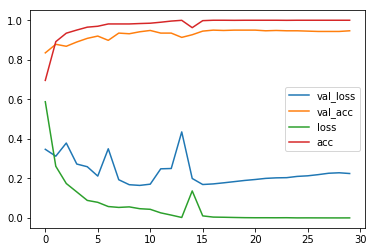

In [18]:
plt.plot(x_axis,His['val_loss'],label = 'val_loss')
plt.plot(x_axis,His['val_acc'],label = 'val_acc')
plt.plot(x_axis,His['loss'],label = 'loss')
plt.plot(x_axis,His['acc'],label = 'acc')
plt.legend()